## CSGO Winning Team Prediction

### 1. Import the final state

In [1]:
from google.colab import drive
drive.mount('/content/drive')
root_path = "/content/drive/MyDrive/GRID Datajam/CCT-Online-Finals-1"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
first_filepath = f"{root_path}/2578928_state.json"
second_filepath = f"{root_path}/2579048_state.json"
third_filepath = f"{root_path}/2579089_state.json"

In [3]:
import json
def load_json(filepath):
    with open(filepath, 'r') as json_file:
        res = json.load(json_file)
    return res

In [4]:
first = load_json(first_filepath)
second = load_json(second_filepath)
third = load_json(third_filepath)

In [5]:
game_1, game_2 = first['games']
game_3, game_4 = second['games']
game_5, game_6 = third['games']

### 2. Extract Historical Data

In [6]:
import pandas as pd
from pandas.api.types import is_float_dtype

def get_player_stats_per_round(game_data, columns):
    player_stats_per_round = pd.json_normalize(data=game_data,
                                record_path=["segments", "teams", "players"],
                                meta=["map",["segments", "id"], ["segments", "teams", "name"],["segments", "teams", "side"]])
    player_stats_per_round['map'] = player_stats_per_round['map'].apply(lambda x: x['name'])
    player_stats_per_round['roundSequence'] = player_stats_per_round['segments.id'].apply(lambda x: x.split("-")[-1])
    player_stats_per_round = player_stats_per_round.rename(columns={"segments.teams.name":"teamName", "segments.teams.side":"side"})

    player_objectives = pd.json_normalize(data=game_data['teams'],
                                record_path=["players", "objectives"],
                                meta=["name", ["players", "name"]])\
                                .pivot_table('completionCount', ["name", "players.name"], "type").reset_index()\
                                        .rename(columns={"name":"teamName", "players.name":"name"})

    players_df = player_stats_per_round.merge(player_objectives, on=['name','teamName'], how="outer")

    return players_df[['roundSequence', 'teamName', 'name', "side", "map", *columns]]

def extract_raw_stats(games_list):
    selected_stats = ["kills", "deaths", "killAssistsGiven", "teamkills", "selfkills", "headshots", "currentHealth", "currentArmor", "damageDealt", "damageTaken", "defuseBomb","explodeBomb","plantBomb"]

    game_stats_list = []

    for cnt, game in enumerate(games):
        game_stats = get_player_stats_per_round(game, selected_stats)
        game_stats.insert(0, 'gameNum', 'game_'+str(cnt+1))
        game_stats_list.append(game_stats)

    combined = pd.concat(game_stats_list).reset_index(drop=True).fillna(0)

    for col in combined.columns:
        if is_float_dtype(combined[col]):
            combined[col] = combined[col].astype('Int64')

    return combined

In [7]:
games = [game_1, game_2, game_3, game_4, game_5, game_6]

In [8]:
raw_stats = extract_raw_stats(games)

In [9]:
raw_stats

,gameNum,roundSequence,teamName,name,side,map,kills,deaths,killAssistsGiven,teamkills,selfkills,headshots,currentHealth,currentArmor,damageDealt,damageTaken,defuseBomb,explodeBomb,plantBomb
0,game_1,1,forZe,r3salt,terrorists,inferno,4,0,0,0,0,4,17,65,395,83,2,0,0
1,game_1,2,forZe,r3salt,terrorists,inferno,0,0,0,0,0,0,100,100,0,0,2,0,0
2,game_1,3,forZe,r3salt,terrorists,inferno,1,0,0,0,0,1,100,100,100,0,2,0,0
3,game_1,4,forZe,r3salt,terrorists,inferno,0,1,0,0,0,0,0,0,0,100,2,0,0
4,game_1,5,forZe,r3salt,terrorists,inferno,0,1,0,0,0,0,0,0,26,100,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665,game_6,22,forZe,Jerry,terrorists,nuke,0,1,0,0,0,0,0,0,97,100,1,0,0
1666,game_6,23,forZe,Jerry,terrorists,nuke,1,1,0,0,0,0,0,0,60,91,1,0,0
1667,game_6,24,forZe,Jerry,terrorists,nuke,0,1,0,0,0,0,0,0,0,100,1,0,0
1668,game_6,25,forZe,Jerry,terrorists,nuke,0,1,0,0,0,0,0,0,0,100,1,0,0


In [303]:
raw_stats.to_csv("raw_player_stats.csv")

### 3. Feature Engineering

Statistical features over the past few games to indicate player performance, such as:
- Average kills/death/assists per game
- Average number of headshots per game
- Average number of bombs defused/planted/exploded per game
- Average damage dealt per round
- Average damage taken per round
- Average ending health/armor per round

These are recomputed with new information after completion og every game, i.e. features for predicting game 5's match will include information from games 1-4, and prediction for game 6's match includes information from games 1-5.


In [81]:
import numpy as np

def compute_aggregated_stats(df):

    per_round = df.groupby(["teamName","name",'side']).agg(
                                          avg_endinghealth_per_round=('currentHealth','mean'),
                                          avg_endingarmor_per_round=('currentArmor','mean'),
                                          avg_damageDealt_per_round=('damageDealt','mean'),
                                          avg_damageTaken_per_round=('damageTaken','mean')
                                          )
    sum_per_game = df.groupby(["teamName","name","gameNum",'side']).agg(
                                                total_kills = ('kills', 'sum'),
                                                total_deaths = ('deaths', 'sum'),
                                                total_assists=('killAssistsGiven','sum'),
                                                total_teamkills=('teamkills','sum'),
                                                total_selfkills=('selfkills','sum'),
                                                total_headshots=('headshots','sum'),
                                                total_bombs_defused=('defuseBomb','sum'),
                                                total_bombs_exploded=('explodeBomb','sum'),
                                                total_bombs_planted=('plantBomb','sum'))

    per_game =  sum_per_game.groupby(["teamName","name",'side']).agg(
                                                        avg_kills_per_game=('total_kills','mean'),
                                                        avg_deaths_per_game=('total_deaths','mean'),
                                                        avg_assists_per_game=('total_assists','mean'),
                                                        avg_teamkills_per_game=('total_teamkills','mean'),
                                                        avg_selfkills_per_game=('total_selfkills','mean'),
                                                        avg_headshots_per_game=('total_headshots','mean'),
                                                        avg_bombs_defused_per_game=('total_bombs_defused','mean'),
                                                        avg_bombs_exploded_per_game=('total_bombs_exploded','mean'),
                                                        avg_bombs_planted_per_game=('total_bombs_planted','mean'))

    agg_df = per_round.join(per_game, on=["teamName","name",'side'])
    return agg_df

In [82]:
import warnings
def compute_features(stats_df, upcoming_teams):
    players = []
    for team in upcoming_teams:
        for player in team['players']:
            info = (team['name'], player['name'], team['side'])
            players.append(info)

    try:
        features_df = stats_df.loc[players]
    except KeyError as e:
        warnings.warn(f"{e}. Ignoring missing...",Warning)
        features_df = stats_df.loc[stats_df.index.isin(players)]

    features_df = features_df.reset_index()

    features_df["playerNum"] = 'player_'+(features_df.groupby("teamName")["avg_kills_per_game"].rank(method="first", ascending=False).astype(int).astype(str))
    features_df['teamNum']= 'team_'+ (features_df['teamName'].rank(method='dense', ascending=True).astype(int).astype(str))

    features_df = features_df.sort_values(["teamNum", "playerNum"],ascending=True)

    return features_df

In [83]:
def compute_labels(teams_data):
    # cant use the won flag, so taking max score
    score = {team['name']:team['score'] for team in teams_data}
    score = {key: value for key, value in sorted(score.items())}
    winning_team = max(score, key=score.get)
    labels = np.array([1 if team['name'] == winning_team else 0 for team in teams_data])
    return labels

In [455]:
# due to lack of historical data, we will use information from games 1-3 as input for games 1-4

game_1_agg_df = compute_aggregated_stats(raw_stats[raw_stats['gameNum'].isin(['game_1','game_2','game_3'])])
game_1_features = compute_features(game_1_agg_df, game_1['teams'])
game_1_labels = compute_labels(game_1['teams'])

game_2_agg_df = compute_aggregated_stats(raw_stats[raw_stats['gameNum'].isin(['game_1','game_2','game_3'])])
game_2_features = compute_features(game_2_agg_df, game_2['teams'])
game_2_labels = compute_labels(game_2['teams'])

game_3_agg_df = compute_aggregated_stats(raw_stats[raw_stats['gameNum'].isin(['game_1','game_2','game_3'])])
game_3_features = compute_features(game_3_agg_df, game_3['teams'])
game_3_labels = compute_labels(game_3['teams'])

game_4_agg_df = compute_aggregated_stats(raw_stats[raw_stats['gameNum'].isin(['game_1','game_2','game_3'])])
game_4_features = compute_features(game_4_agg_df, game_4['teams'])
game_4_labels = compute_labels(game_4['teams'])

game_5_agg_df = compute_aggregated_stats(raw_stats[raw_stats['gameNum'].isin(['game_1','game_2','game_3', 'game_4'])])
game_5_features = compute_features(game_5_agg_df, game_5['teams'])
game_5_labels = compute_labels(game_5['teams'])

game_6_agg_df = compute_aggregated_stats(raw_stats[raw_stats['gameNum'].isin(['game_1','game_2','game_3', 'game_4', 'game_5'])])
game_6_features = compute_features(game_6_agg_df, game_6['teams'])
game_6_labels = compute_labels(game_6['teams'])

In [460]:
game_5_agg_df

avg_endinghealth_per_round  \
teamName name    side                                             
9INE     Goofy   counter-terrorists                   23.153846   
                 terrorists                           17.030303   
         KEi     counter-terrorists                    9.076923   
                 terrorists                           15.515152   
         Kylar   counter-terrorists                   23.884615   
                 terrorists                           22.363636   
         hades   counter-terrorists                   24.423077   
                 terrorists                           15.181818   
         mynio   counter-terrorists                   17.038462   
                 terrorists                           18.575758   
ECSTATIC Nodios  counter-terrorists                   40.636364   
                 terrorists                           25.878788   
         Queenix counter-terrorists                   43.181818   
                 terrorists                           26.424242   
         kraghen counter-terrorists                   44.227273   
                 terrorists                           12.666667   
         maNkz   counter-terrorists                   30.500000   
                 terrorists                           24.696970   
         salazar counter-terrorists                   43.909091   
                 terrorists                           37.181818   
forZe    Jerry   counter-terrorists                   29.378788   
                 terrorists                           25.166667   
         Krad    counter-terrorists                   32.621212   
                 terrorists                           14.500000   
         r3salt  counter-terrorists                   21.363636   
                 terrorists                           14.291667   
         shalfey counter-terrorists                   27.803030   
                 terrorists                           22.083333   
         zorte   counter-terrorists                   38.454545   
                 terrorists                           24.479167   

                                     avg_endingarmor_per_round  \
teamName name    side                                            
9INE     Goofy   counter-terrorists                  28.884615   
                 terrorists                          18.060606   
         KEi     counter-terrorists                  18.038462   
                 terrorists                          18.212121   
         Kylar   counter-terrorists                  26.307692   
                 terrorists                          25.484848   
         hades   counter-terrorists                  25.961538   
                 terrorists                          21.090909   
         mynio   counter-terrorists                  17.538462   
                 terrorists                          18.151515   
ECSTATIC Nodios  counter-terrorists                  44.681818   
                 terrorists                          28.303030   
         Queenix counter-terrorists                  49.818182   
                 terrorists                          34.212121   
         kraghen counter-terrorists                  51.909091   
                 terrorists                          21.363636   
         maNkz   counter-terrorists                  30.681818   
                 terrorists                          31.272727   
         salazar counter-terrorists                  52.590909   
                 terrorists                          39.848485   
forZe    Jerry   counter-terrorists                  29.621212   
                 terrorists                          29.541667   
         Krad    counter-terrorists                  34.363636   
                 terrorists                          22.020833   
         r3salt  counter-terrorists                  23.666667   
                 terrorists                          20.041667   
         shalfey counter-terrorists         

In [461]:
game_5_agg_df.to_csv("agg_player_stats.csv")

In [287]:
game_5_features

,teamName,name,side,avg_endinghealth_per_round,avg_endingarmor_per_round,avg_damageDealt_per_round,avg_damageTaken_per_round,avg_kills_per_game,avg_deaths_per_game,avg_assists_per_game,avg_teamkills_per_game,avg_selfkills_per_game,avg_headshots_per_game,avg_bombs_defused_per_game,avg_bombs_exploded_per_game,avg_bombs_planted_per_game,playerNum,teamNum,gameNum
2,ECSTATIC,Nodios,terrorists,25.878788,28.303030,74.757576,73.212121,12.50,11.50,0.50,0.0,0.0,9.50,0.0,0.0,0.0,player_1,team_1,game_0
4,ECSTATIC,kraghen,terrorists,12.666667,21.363636,67.575758,86.000000,11.50,12.50,0.50,0.0,0.0,6.00,9.0,7.5,7.5,player_2,team_1,game_0
0,ECSTATIC,Queenix,terrorists,26.424242,34.212121,73.090909,71.151515,10.50,10.50,2.50,0.0,0.0,8.50,0.0,7.5,39.0,player_3,team_1,game_0
3,ECSTATIC,salazar,terrorists,37.181818,39.848485,65.393939,62.454545,10.00,9.50,1.00,0.0,0.0,3.50,9.0,33.0,67.5,player_4,team_1,game_0
1,ECSTATIC,maNkz,terrorists,24.696970,31.272727,74.181818,74.000000,9.50,11.00,3.00,0.0,0.0,7.00,0.0,34.5,58.5,player_5,team_1,game_0
5,forZe,shalfey,counter-terrorists,27.803030,28.212121,86.939394,71.575758,14.25,11.25,1.75,0.0,0.0,6.50,4.5,4.5,34.5,player_1,team_2,game_0
7,forZe,Krad,counter-terrorists,32.621212,34.363636,95.560606,67.333333,13.50,10.00,3.00,0.0,0.0,7.75,8.25,4.5,9.0,player_2,team_2,game_0
6,forZe,zorte,counter-terrorists,38.454545,41.287879,69.409091,61.545455,12.00,8.50,1.25,0.0,0.0,3.00,7.5,9.0,24.75,player_3,team_2,game_0
8,forZe,r3salt,counter-terrorists,21.363636,23.666667,67.393939,78.075758,10.00,12.00,2.00,0.0,0.0,6.25,9.0,0.0,13.5,player_4,team_2,game_0
9,forZe,Jerry,counter-terrorists,29.378788,29.621212,69.030303,69.954545,9.00,10.75,2.75,0.0,0.0,2.75,0.0,0.0,9.0,player_5,team_2,game_0


In [413]:
features = ['avg_endinghealth_per_round',
       'avg_endingarmor_per_round', 'avg_damageDealt_per_round',
       'avg_damageTaken_per_round', 'avg_kills_per_game',
       'avg_deaths_per_game', 'avg_assists_per_game', 'avg_teamkills_per_game',
       'avg_selfkills_per_game', 'avg_headshots_per_game',
       'avg_bombs_defused_per_game', 'avg_bombs_exploded_per_game',
       'avg_bombs_planted_per_game']

def combine_and_pivot(features_list):
    dfs = []
    for cnt, df in enumerate(features_list):
        df['gameNum'] = 'game_'+str(cnt)
        dfs.append(df)
    concat_df = pd.concat(dfs)

    pivoted = concat_df.pivot(index='gameNum',columns=['teamNum','playerNum'],values=features).reset_index(drop=True)
    pivoted.columns = ['_'.join(col) for col in pivoted.columns.values]

    pivoted = pivoted.fillna(0)

    return pivoted

In [414]:
trainX = combine_and_pivot([game_1_features, game_2_features, game_3_features, game_4_features])

In [451]:
trainX

,avg_endinghealth_per_round_team_1_player_1,avg_endinghealth_per_round_team_1_player_2,avg_endinghealth_per_round_team_1_player_3,avg_endinghealth_per_round_team_1_player_4,avg_endinghealth_per_round_team_1_player_5,avg_endinghealth_per_round_team_2_player_1,avg_endinghealth_per_round_team_2_player_2,avg_endinghealth_per_round_team_2_player_3,avg_endinghealth_per_round_team_2_player_4,avg_endinghealth_per_round_team_2_player_5,...,avg_bombs_planted_per_game_team_1_player_1,avg_bombs_planted_per_game_team_1_player_2,avg_bombs_planted_per_game_team_1_player_3,avg_bombs_planted_per_game_team_1_player_4,avg_bombs_planted_per_game_team_1_player_5,avg_bombs_planted_per_game_team_2_player_1,avg_bombs_planted_per_game_team_2_player_2,avg_bombs_planted_per_game_team_2_player_3,avg_bombs_planted_per_game_team_2_player_4,avg_bombs_planted_per_game_team_2_player_5
0,43.909091,30.5000,44.227273,43.181818,40.636364,23.342105,14.473684,13.342105,25.684211,19.5,...,51.0,42.0,2.0,17.0,0.0,16.666667,11.333333,16.0,11.333333,34.0
1,43.909091,30.5000,44.227273,43.181818,40.636364,23.342105,14.473684,13.342105,25.684211,19.5,...,51.0,42.0,2.0,17.0,0.0,16.666667,11.333333,16.0,11.333333,34.0
2,28.500000,13.9375,26.312500,25.125000,15.187500,23.342105,14.473684,13.342105,25.684211,19.5,...,48.0,32.0,48.0,16.0,0.0,16.666667,11.333333,16.0,11.333333,34.0
3,28.500000,13.9375,26.312500,25.125000,15.187500,23.342105,14.473684,13.342105,25.684211,19.5,...,48.0,32.0,48.0,16.0,0.0,16.666667,11.333333,16.0,11.333333,34.0


In [415]:
trainY = np.array([game_1_labels, game_2_labels, game_3_labels, game_4_labels])

In [92]:
trainY

array([[0, 1],
       [0, 1],
       [1, 0],
       [1, 0]])

In [456]:
testX = combine_and_pivot([game_5_features, game_6_features])

In [457]:
testX

,avg_endinghealth_per_round_team_1_player_1,avg_endinghealth_per_round_team_1_player_2,avg_endinghealth_per_round_team_1_player_3,avg_endinghealth_per_round_team_1_player_4,avg_endinghealth_per_round_team_1_player_5,avg_endinghealth_per_round_team_2_player_1,avg_endinghealth_per_round_team_2_player_2,avg_endinghealth_per_round_team_2_player_3,avg_endinghealth_per_round_team_2_player_4,avg_endinghealth_per_round_team_2_player_5,...,avg_bombs_planted_per_game_team_1_player_1,avg_bombs_planted_per_game_team_1_player_2,avg_bombs_planted_per_game_team_1_player_3,avg_bombs_planted_per_game_team_1_player_4,avg_bombs_planted_per_game_team_1_player_5,avg_bombs_planted_per_game_team_2_player_1,avg_bombs_planted_per_game_team_2_player_2,avg_bombs_planted_per_game_team_2_player_3,avg_bombs_planted_per_game_team_2_player_4,avg_bombs_planted_per_game_team_2_player_5
0,25.878788,12.666667,26.424242,37.181818,24.696970,27.803030,32.621212,38.454545,21.363636,29.378788,...,0.0,7.500000,39.0,67.500000,58.5,34.5,9.0,24.75,13.5,9.0
1,37.756757,34.189189,28.027027,37.270270,29.567568,22.793651,29.063492,22.396825,17.444444,18.412698,...,49.0,11.333333,38.0,11.333333,5.0,36.4,28.0,9.80,9.8,12.6


In [329]:
testY = [game_5_labels, game_6_labels]

#### Modelling

In [531]:
keras.backend.clear_session()

In [532]:
import tensorflow as tf
import keras
from keras.optimizers import Adam

model = keras.Sequential(
    [
        keras.layers.Dense(64, activation="relu", name="layer1"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation="relu", name="layer2"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(16, activation="relu", name="layer3"),
        keras.layers.Dense(2, activation="softmax")
    ]
)

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [533]:
tf.random.set_seed(42)
history = model.fit(trainX, trainY, batch_size=2,epochs=5)

Epoch 1/5
2/2 [==============================] - 3s 17ms/step - loss: 8.0540 - accuracy: 0.7500
Epoch 2/5
2/2 [==============================] - 0s 9ms/step - loss: 6.5102 - accuracy: 0.7500
Epoch 3/5
2/2 [==============================] - 0s 9ms/step - loss: 4.6804 - accuracy: 0.5000
Epoch 4/5
2/2 [==============================] - 0s 8ms/step - loss: 9.5361 - accuracy: 0.5000
Epoch 5/5
2/2 [==============================] - 0s 9ms/step - loss: 6.6450 - accuracy: 0.2500


<Axes: >

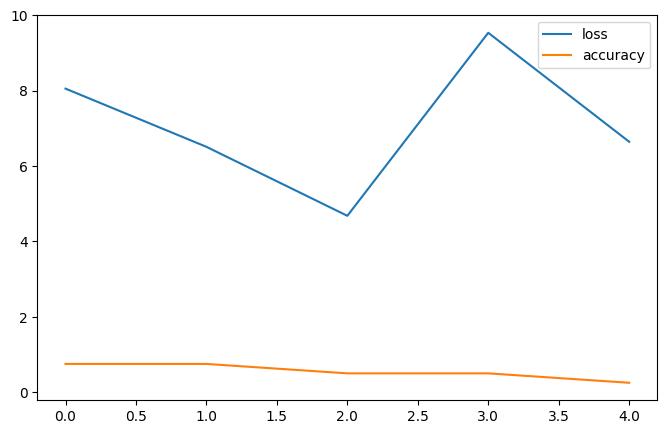

In [534]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [535]:
probas = model.predict(testX)
probas

1/1 [==============================] - 0s 145ms/step


array([[0.29693154, 0.7030685 ],
       [0.12049074, 0.87950927]], dtype=float32)

In [536]:
np.average(probas, axis=0)

array([0.20871113, 0.79128885], dtype=float32)

In [537]:
model.save('csgo_game_prediction_model.keras')